In [32]:
# FILE_NAME = 'inter_dataset.csv'
FILE_NAME = '2800_HK_Final.csv'

from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import datetime

%load_ext tensorboard
print(tf.version.VERSION)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.0.0


In [20]:
# split dataset 80% train, 20% validation, 2021为dev
def split_dataset(dataset):
#     size = dataset.shape[0]
    size = 2915
    
    train_size = 2668 * 80 // 100
    test_size = 2668 * 20 // 100
    
    return dataset[0:train_size, :], dataset[train_size:(train_size + test_size), :], dataset[(train_size + test_size):size, :]

def plot_series(time, series, lab, form='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], form, label=lab)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)

def tf_dataset(series_x, series_y, batch_size, shuffle_buffer, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((series_x, series_y))
    if shuffle:
        ds = ds.cache().shuffle(shuffle_buffer).batch(batch_size).repeat()
    else:
        ds = ds.cache().batch(batch_size).repeat()

    return ds

def create_window_dataset(ds, lb, window_size):
    windowed_dataset = []
    labels = []
    for i in range(window_size, ds.shape[0] + 1):
        windowed_dataset.append(ds[i - window_size:i])
        labels.append(lb[i - 1])
        
    return np.array(windowed_dataset), np.array(labels)

def get_metrics_result(metrics, true_labels, predicted_labels):    
    metrics_result = []
    for metric in metrics:
        metric.reset_states()
        metric.update_state(true_labels, predicted_labels)
        metrics_result.append(metric.result().numpy())
    
    return metrics_result

In [21]:
data = pd.read_csv(FILE_NAME, sep=',')
data = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Close']]
data.columns.values[6] = "Next Price"
data.head()

,Open,High,Low,Close,Adj Close,Volume,Next Price
0,21.350000,21.450001,21.250000,21.400000,21.400000,12199955.0,21.400000
1,21.400000,21.500000,21.299999,21.400000,21.400000,14829634.0,21.400000
2,21.450001,21.500000,21.200001,21.400000,21.400000,19322375.0,21.400000
3,21.299999,21.450001,21.299999,21.350000,21.350000,5128681.0,21.350000
4,21.400000,21.400000,21.100000,21.299999,21.299999,5659053.0,21.299999


In [22]:
dataset = data['Next Price']
dataset.loc[dataset.shape[0]]= 0.0
dataset = dataset.iloc[1:]
data.iloc[:, -1] = dataset.values
dataset = data[:-1]

dataset_to_numpy = dataset.values
dataset.head()

,Open,High,Low,Close,Adj Close,Volume,Next Price
0,21.350000,21.450001,21.250000,21.400000,21.400000,12199955.0,21.400000
1,21.400000,21.500000,21.299999,21.400000,21.400000,14829634.0,21.400000
2,21.450001,21.500000,21.200001,21.400000,21.400000,19322375.0,21.350000
3,21.299999,21.450001,21.299999,21.350000,21.350000,5128681.0,21.299999
4,21.400000,21.400000,21.100000,21.299999,21.299999,5659053.0,21.200001


# Split dataset

In [23]:
train_dataset, cross_validation_dataset, dev_dataset = split_dataset(dataset_to_numpy)

print("Dataset shape: {:s}".format(str(dataset_to_numpy.shape)))
print("Train dataset shape: {:s}".format(str(train_dataset.shape)))
print("Cross validation dataset shape: {:s}".format(str(cross_validation_dataset.shape)))
print("Dev dataset shape: {:s}".format(str(dev_dataset.shape)))

Dataset shape: (2956, 7)
Train dataset shape: (2134, 7)
Cross validation dataset shape: (533, 7)
Dev dataset shape: (248, 7)


# Stock prices graph

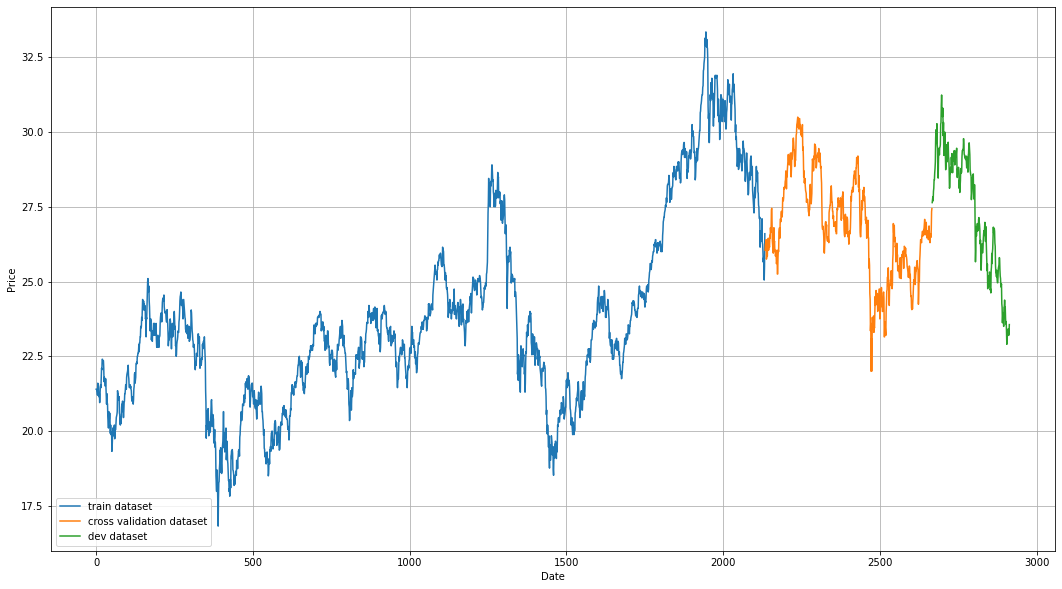

In [24]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(train_dataset.shape[0]), train_dataset[:, -1], "train dataset")
plot_series(np.arange(train_dataset.shape[0], (cross_validation_dataset.shape[0] + train_dataset.shape[0])), cross_validation_dataset[:, -1], "cross validation dataset")
plot_series(np.arange((cross_validation_dataset.shape[0] + train_dataset.shape[0]), (cross_validation_dataset.shape[0]+ train_dataset.shape[0] + dev_dataset.shape[0])), dev_dataset[:, -1], "dev dataset")
plt.legend(loc='lower left')

# Data normalization

In [25]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_dataset[:, 0:-1])

train_dataset_normalized = scaler.transform(train_dataset[:, 0:-1])
cross_validation_dataset_normalized = scaler.transform(cross_validation_dataset[:, 0:-1])
dev_dataset_normalized = scaler.transform(dev_dataset[:, 0:-1])

# Create window dataset

In [26]:
WINDOW_SIZE = 15
BATCH_SIZE = 64

windowed_dataset_train, labels_train = create_window_dataset(train_dataset[:, 0:-1], train_dataset[:, -1], WINDOW_SIZE)

windowed_dataset_train, labels_train = create_window_dataset(train_dataset_normalized, train_dataset[:, -1], WINDOW_SIZE)
train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000)
unshuffled_train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000, False)

windowed_dataset_validation, labels_validation = create_window_dataset(cross_validation_dataset_normalized, cross_validation_dataset[:, -1], WINDOW_SIZE)
cross_validation_set = tf_dataset(windowed_dataset_validation, labels_validation, BATCH_SIZE, 1000, False)

windowed_dataset_dev, labels_dev = create_window_dataset(dev_dataset_normalized, dev_dataset[:, -1], WINDOW_SIZE)
dev_set = tf_dataset(windowed_dataset_dev, labels_dev, 1, 1000, False)

In [27]:
TRAIN_STEP = math.ceil(windowed_dataset_train.shape[0] / BATCH_SIZE)
VALIDATION_STEP = math.ceil(windowed_dataset_validation.shape[0] / BATCH_SIZE)
DEV_STEP = windowed_dataset_dev.shape[0]

# Define model

In [28]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=5,
                           strides=1,
                           padding="causal",
                           activation="relu",
                           input_shape=windowed_dataset_train.shape[-2:]),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-4,
                                                             decay_steps=100000,
                                                             decay_rate=0.98,
                                                             staircase=False)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.8),
              metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15, 64)            1984      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 13, 128)           82432     
_________________________________________________________________
lstm_1 (LSTM)                (None, 13, 128)           131584    
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0

# Train model

In [ ]:
log_dir = "logs\\" + datetime.datetime.now().strftime("%d-%m-%Y_%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_set,
                    epochs=1000,
                    steps_per_epoch=TRAIN_STEP,
                    validation_data=cross_validation_set,
                    validation_steps=VALIDATION_STEP,
                    verbose=0,
                    callbacks=[tensorboard_callback])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-19373b4a66b4>", line 10, in <module>
    callbacks=[tensorboard_callback])
  File "D:\Anaconda\envs\py36\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 728, in fit
    use_multiprocessing=use_multiprocessing)
  File "D:\Anaconda\envs\py36\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 324, in fit
    total_epochs=epochs)
  File "D:\Anaconda\envs\py36\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 123, in run_one_epoch
    batch_outs = execution_function(iterator)
  File "D:\Anaconda\envs\py36\lib\site-packages\tensorflow_core\python\keras\engine\training_v2_utils.py", line 86, in execution_function
    distributed_function(input_fn))
  File "D:\Anaconda\envs\py36\lib\site-packages\tenso

## Save model weights

In [30]:
model.save_weights('weights/inter_model_weights.ckpt')

## Load model weights

In [27]:
model.load_weights('weights/inter_model_weights.ckpt')

# Predictions

In [31]:
forecast_train = model.predict(unshuffled_train_set, steps=TRAIN_STEP)
forecast_validation = model.predict(cross_validation_set, steps=VALIDATION_STEP)
forecast_dev = model.predict(dev_set, steps=DEV_STEP)

## Show predictions

,MAE,MAPE,MSE,RMSE
,,,,
Train,NaN,NaN,NaN,NaN
Validation,NaN,NaN,NaN,NaN
Dev,NaN,NaN,NaN,NaN


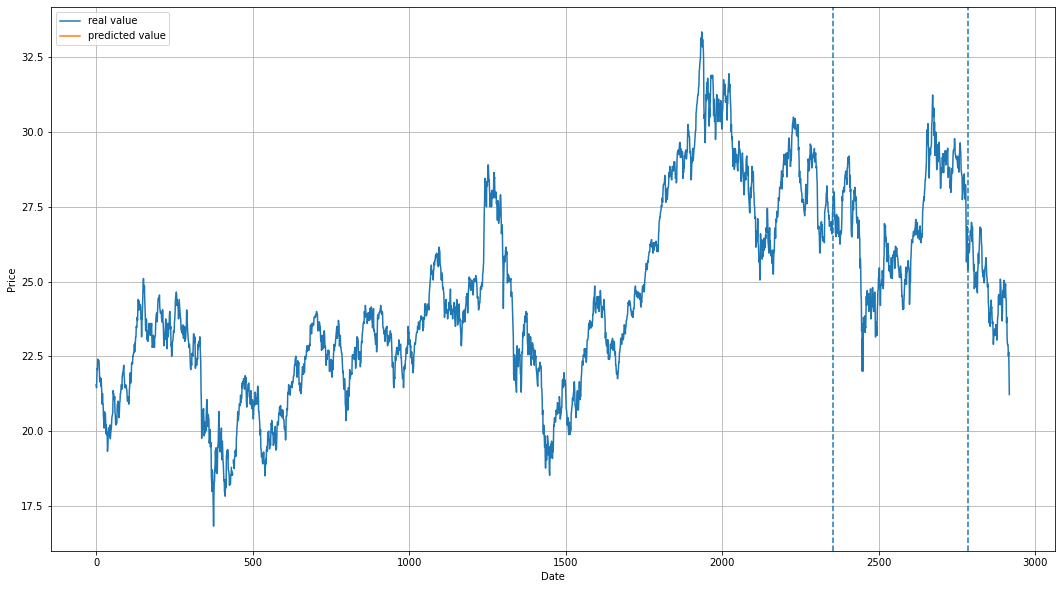

In [33]:
total_forecast = np.concatenate((forecast_train[:,0], forecast_validation[:,0], forecast_dev[:,0]))
total_labels = np.concatenate((labels_train, labels_validation, labels_dev))

plt.figure(figsize=(18, 10))
plot_series(np.arange(total_labels.shape[0]), total_labels, "real value")
plot_series(np.arange(total_labels.shape[0]), total_forecast, "predicted value")
xpositions = [labels_train.shape[0], (labels_train.shape[0] + labels_validation.shape[0])]
for xp in xpositions:
    plt.axvline(x=xp, linestyle='--')
plt.legend(loc='upper left')

metrics = [
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanSquaredError(),
    tf.keras.metrics.RootMeanSquaredError()
]
train_metrics = get_metrics_result(metrics, labels_train, forecast_train[:,0])
train_metrics.insert(0, 'Train')
val_metrics = get_metrics_result(metrics, labels_validation, forecast_validation[:,0])
val_metrics.insert(0, 'Validation')
dev_metrics = get_metrics_result(metrics,labels_dev, forecast_dev[:,0])
dev_metrics.insert(0, 'Dev')

COL_NAMES = ['', 'MAE', 'MAPE', 'MSE', 'RMSE']
metrics_table = pd.DataFrame([train_metrics, val_metrics, dev_metrics], columns=COL_NAMES)
metrics_table = metrics_table.set_index([''])
metrics_table.round(3)

## Predictions: Train data

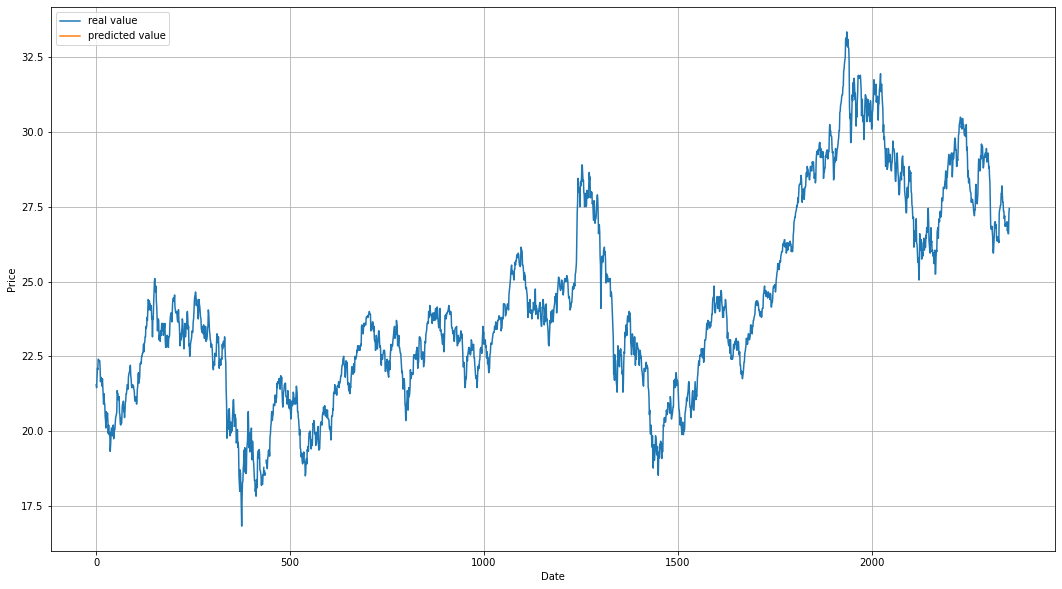

In [30]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(labels_train.shape[0]), labels_train, "real value")
plot_series(np.arange(labels_train.shape[0]), forecast_train[:,0], "predicted value")
plt.legend(loc='upper left')

## Predictions: Validation data

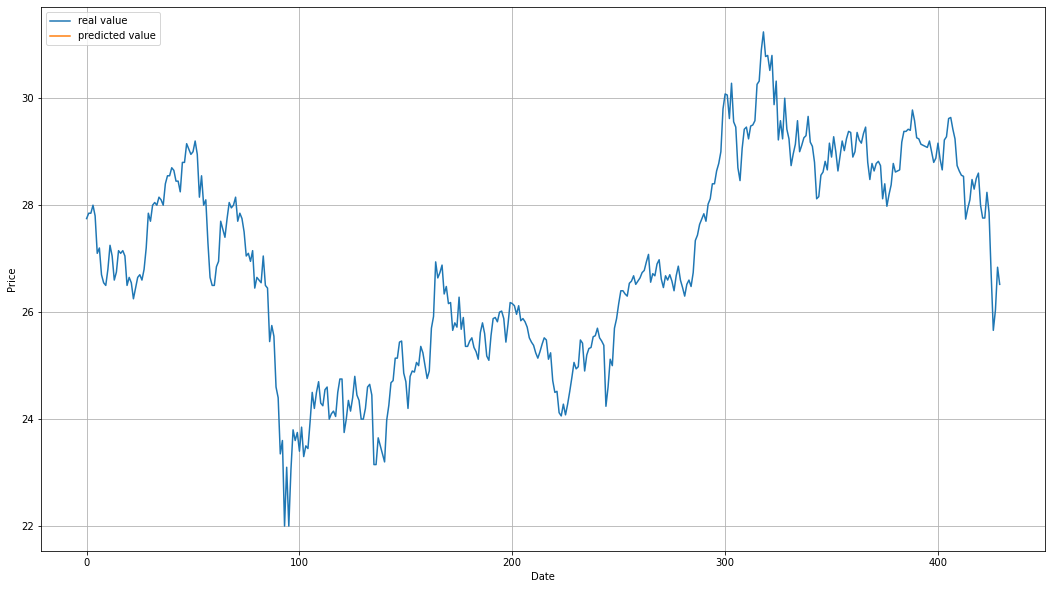

In [31]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(labels_validation.shape[0]), labels_validation, "real value")
plot_series(np.arange(labels_validation.shape[0]), forecast_validation[:,0], "predicted value")
plt.legend(loc='upper left')

## Predictions: Dev data

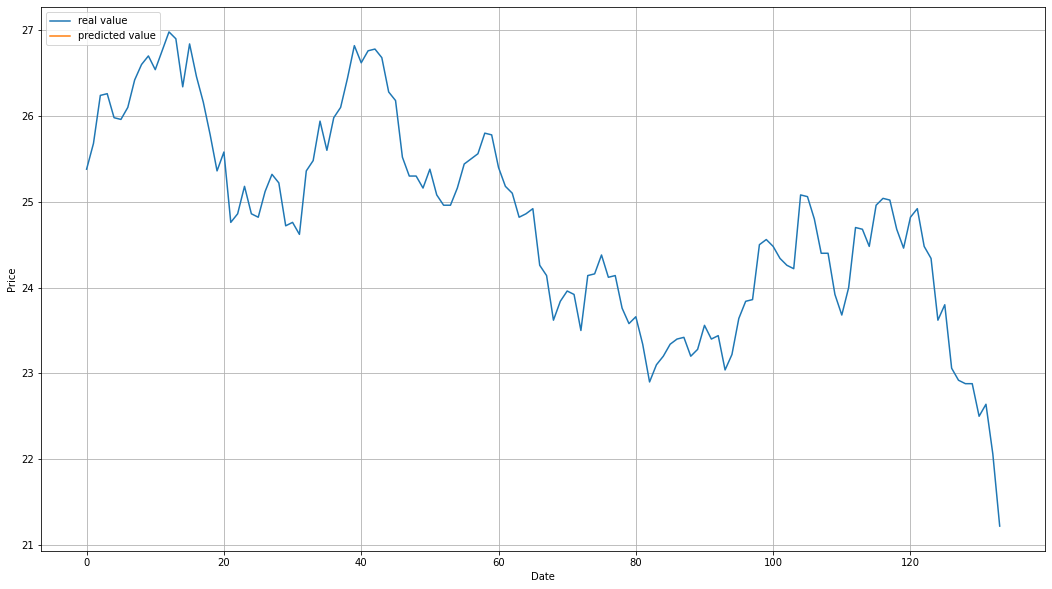

In [32]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(labels_dev.shape[0]), labels_dev, "real value")
plot_series(np.arange(labels_dev.shape[0]), forecast_dev[:,0], "predicted value")
plt.legend(loc='upper left')